<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Домашнее задание 5: АБ-тест
</center>

**ФИО:**

## Общая информация

__Дата выдачи:__ 07.04.2025

__Дедлайн:__ 23:59MSK 20.04.2025

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с оценкой дисперсии $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента.

- Если $z < z_{1 - \alpha},$ нулевая гипотеза не отвергается (похоже, что верна). Расстояние маленькое, разницы нет.
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться.

> Ничего не понятно? Тогда вам в лекции. Ниже подборка:  

- [Наша лекция про АБ]( )
- [Неделя про проверку гипотез с курсеры](https://www.youtube.com/watch?v=Zv-5gbJtofk&list=PLCf-cQCe1FRxTgNPwcRSkBjvtE8DEm7rU)


## Задания


__а) [1 балл]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [39]:
from scipy.stats import norm

def asy_mean_test(x_control, x_treatment, alternative='larger'):
    x_control = np.asarray(x_control)
    x_treatment = np.asarray(x_treatment)

    mean_t = np.mean(x_treatment)
    mean_c = np.mean(x_control)

    z_obs = (mean_t - mean_c) / np.sqrt(mean_t * (1 - mean_t) / len(x_treatment) + mean_c * (1 - mean_c) / len(x_control))

    if alternative == 'larger':
        p_value = 1 - norm.cdf(z_obs)
    elif alternative == 'smaller':
        p_value = norm.cdf(z_obs)
    elif alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_obs)))
    else:
        raise ValueError("Invalid alternative. Choose from 'larger', 'smaller', 'two-sided'.")
    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [ ]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [ ]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [ ]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c
\end{aligned}
$$

__б) [2 балла]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

In [ ]:
def plot_statistics(z_obs_values, p_values):
    sns.set(style='whitegrid')
    plt.figure(figsize=(14, 6))

    # Гистограмма p-value
    plt.subplot(1, 2, 1)
    plt.hist(p_values, bins=50, color='#ff9999', edgecolor='black', alpha=0.8)
    plt.title('Распределение p_value', fontsize=14)
    plt.xlabel('p_value', fontsize=12)
    plt.ylabel('Частота', fontsize=12)

    # Гистограмма z-статистик
    plt.subplot(1, 2, 2)
    plt.hist(z_obs_values, bins=50, color='#00FFFF', edgecolor='black', alpha=0.8)
    plt.title('Распределение z_obs', fontsize=14)
    plt.xlabel('z_obs', fontsize=12)
    plt.ylabel('Частота', fontsize=12)

    plt.tight_layout()
    plt.show()

In [45]:
def distribution(n_simulations, n_obs, effect, p_control = 0.2):
    p_values = []
    z_obs_values = []

    for _ in range(n_simulations):
        z_obs, p_value = asy_mean_test(*gen_sample(n_obs, effect, p_control))
        p_values.append(p_value)
        z_obs_values.append(z_obs)
    plot_statistics(z_obs_values, p_values)

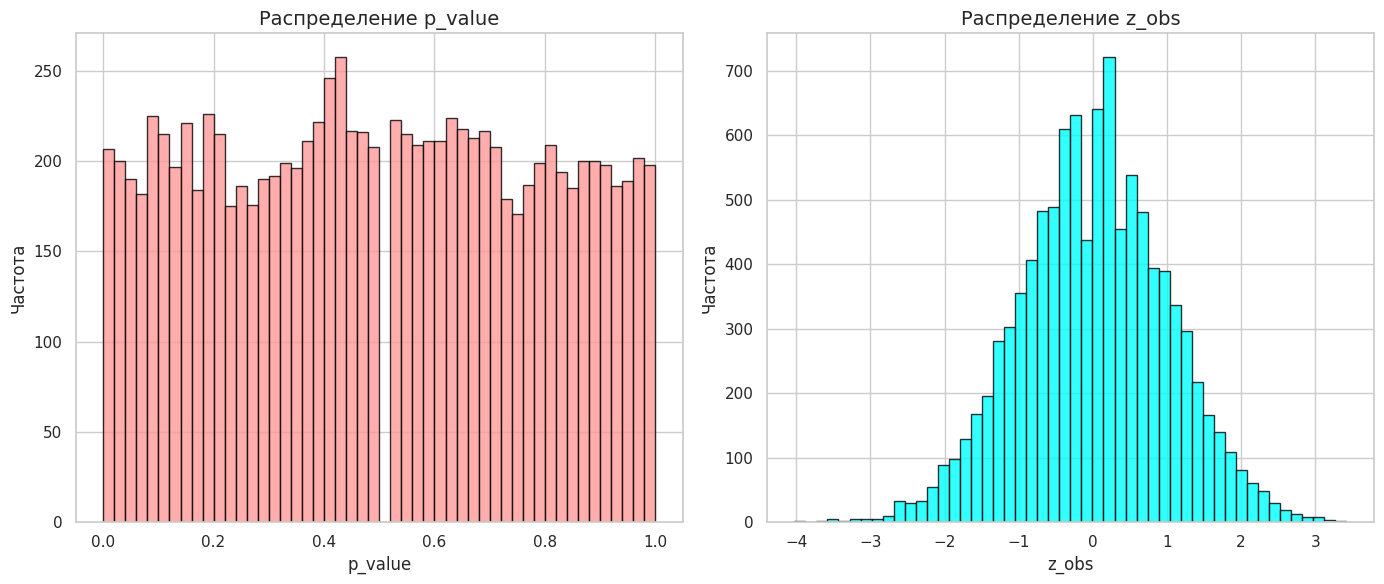

In [46]:
n_simulations = 10**4
n_obs = 1000
distribution(n_simulations, n_obs, 0)

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__

1) p_value является равномерным.

2) z_obs симметрична и центрирована в нуле, что говорит о математическом ожидании равным 0.

3) p_value — это вероятность получить статистику ещё более экстремальную, при условии, что $H_0$ верна, а так как она 100% верна, то p_value должно быть распределено равномерно на [0;1].

4)  Мы сравниваем выборочные средние в контрольной и тестовой группе. При выполнении $H_0$​, разность между ними $\hat{\mu}_t - \hat{\mu}_c$​ в среднем равна 0, а центральная предельная теорема говорит, что такая разность будет распределена нормально с центром в нуле.

__в) [1 балл]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

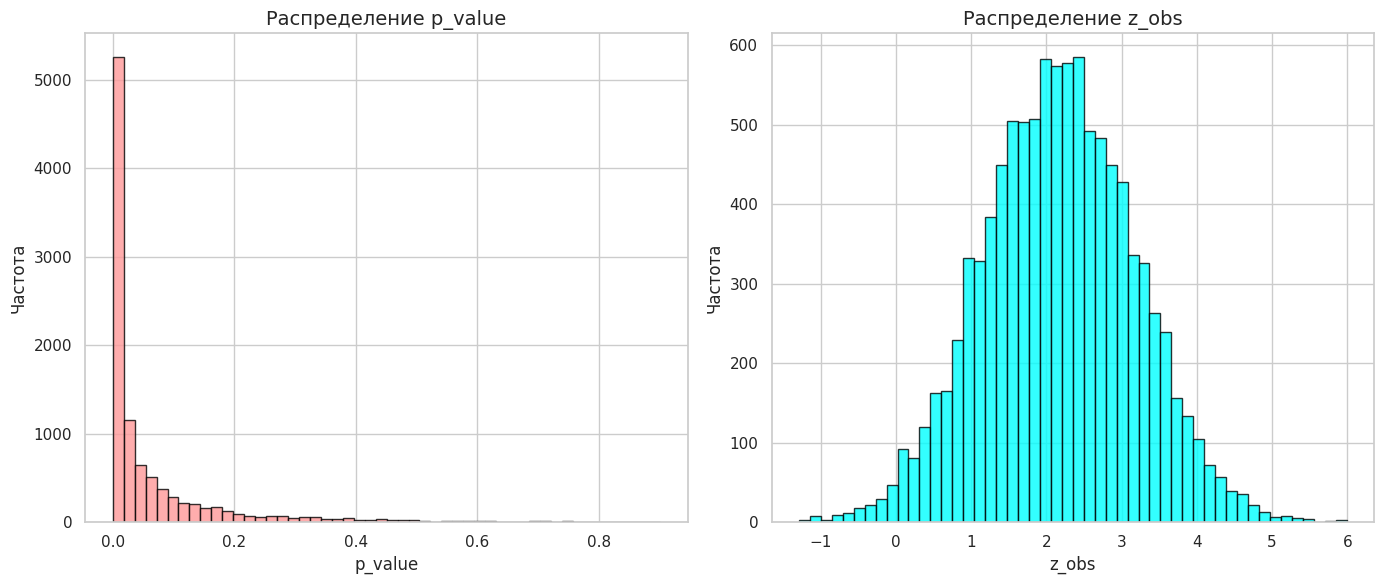

In [47]:
distribution(n_simulations, n_obs, 0.2)

А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

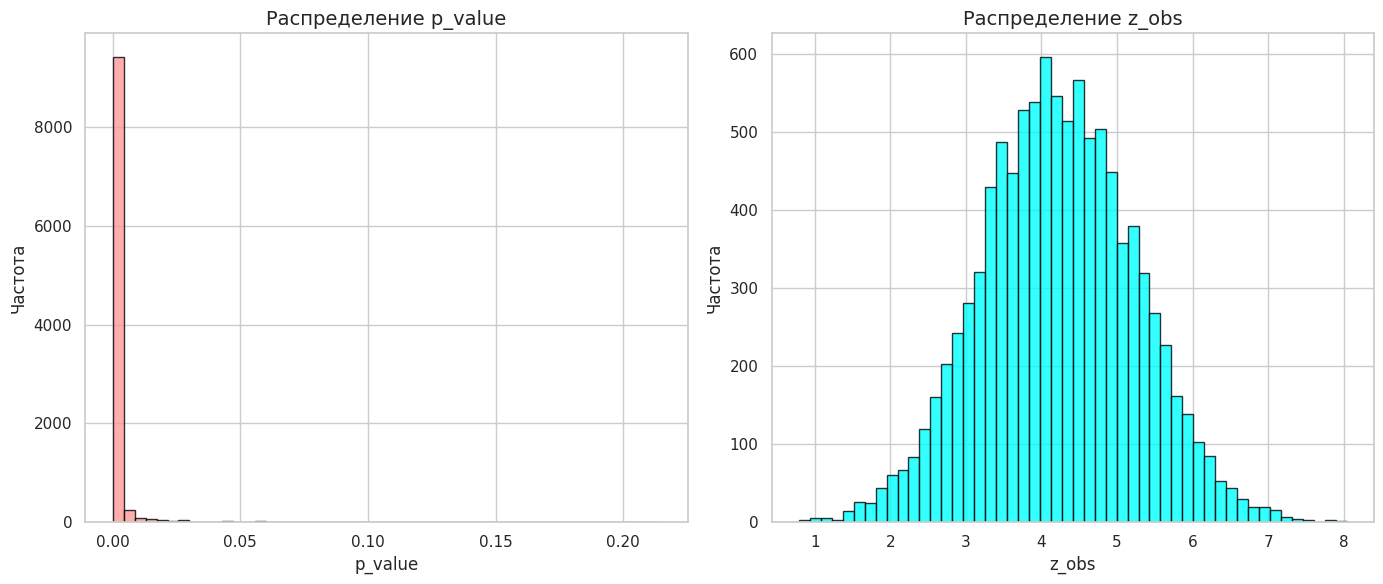

In [41]:
distribution(n_simulations, n_obs, 0.4)

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__

1) Нет, распределние не равномерно, так как p-value — это вероятность получить такое же значение тестовой статистики при условии, что нулевая гипотеза (H₀) верна, и в нашем случае с увеличение эффекта верятность правдивости нулевой гипотезы стремится к 0.

2) В первом случае около 2, во втором около 4, так как статистика чувствительна к различиям между выборками и смещается вправо с увеличением эффекта.

__г) [1 балл]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \text{ выбрана} \mid H_0 \text{ верна}).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два).

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению?

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [104]:
def error_alpha(n_simulations, n_obs, alpha, effect, err, p_control=0.2, output = True):
    false_rejections = 0

    for _ in range(n_simulations):
        x_control, x_treatment = gen_sample(n_obs, effect, p_control)

        z_obs, p_value = asy_mean_test(x_control, x_treatment)

        if p_value < alpha and err == 'alpha':
            false_rejections += 1
        elif p_value >= alpha and err == 'beta':
            false_rejections += 1
    estimated = false_rejections / n_simulations
    if output == True:
        print(f"Заявленный alpha: {alpha}, Оцененный {err}: {estimated:.4f}")
    return estimated

In [95]:
est = error_alpha(n_simulations, n_obs, alpha=0.1, effect=0, err='alpha')

Заявленный alpha: 0.1, Оцененный alpha: 0.0998


Да, значение равны, но есть незначительные погрешности

Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \text{ выбрана} \mid H_A \text{ верна}).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$.

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [96]:
est = error_alpha(n_simulations, n_obs, alpha=0.1, effect=0.2, err='beta')

Заявленный beta: 0.1, Оцененный beta: 0.1883


In [97]:
est = error_alpha(n_simulations, n_obs, alpha=0.05, effect=0.2, err='beta')

Заявленный beta: 0.05, Оцененный beta: 0.2982


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [98]:
est = error_alpha(n_simulations, n_obs, alpha=0.1, effect=0.4, err='beta')

Заявленный beta: 0.1, Оцененный beta: 0.0013


In [99]:
est = error_alpha(n_simulations, n_obs, alpha=0.05, effect=0.4, err='beta')

Заявленный beta: 0.05, Оцененный beta: 0.0056


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__

1) при росте эффекта ошибка уменьшается

2) при уменьешения alpha ошибка увеличится

__д) [1 балл]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`.

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже?

In [103]:
alpha_values = []
beta_values_20 = []
beta_values_40 = []
rng = np.arange(0, 1.01, 0.01)
for alpha in tqdm(rng):
    alpha_values.append(error_alpha(n_simulations, n_obs, alpha=alpha, effect=0, err='alpha', output = False))
    beta_values_20.append(error_alpha(n_simulations, n_obs, alpha=alpha, effect=0.2, err='beta', output = False))
    beta_values_40.append(error_alpha(n_simulations, n_obs, alpha=alpha, effect=0.4, err='beta', output = False))

100%|██████████| 101/101 [1:24:00<00:00, 49.91s/it]


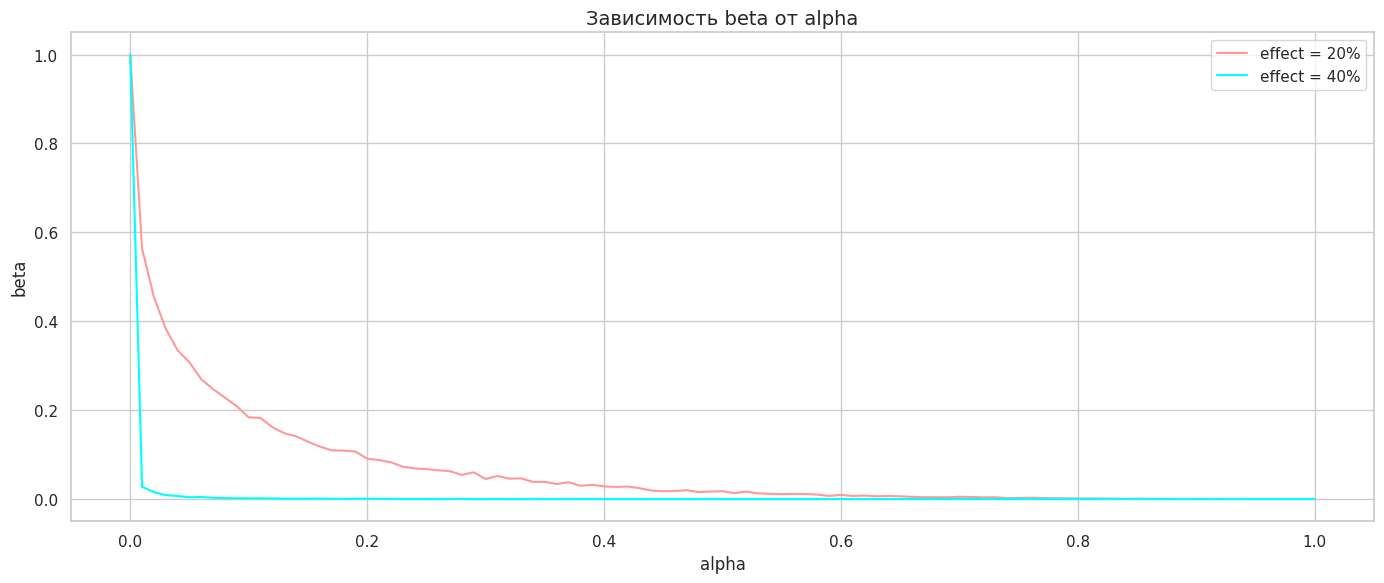

In [116]:
sns.set(style='whitegrid')
plt.figure(figsize=(14, 6))

# beta_values_20
plt.plot(rng, beta_values_20, color='#ff9999', label='effect = 20%')
plt.plot(rng, beta_values_40, color='#00FFFF', label='effect = 40%')

plt.title('Зависимость beta от alpha', fontsize=14)
plt.xlabel('alpha', fontsize=12)
plt.ylabel('beta', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Ниже всего кривая с effect = 40%

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

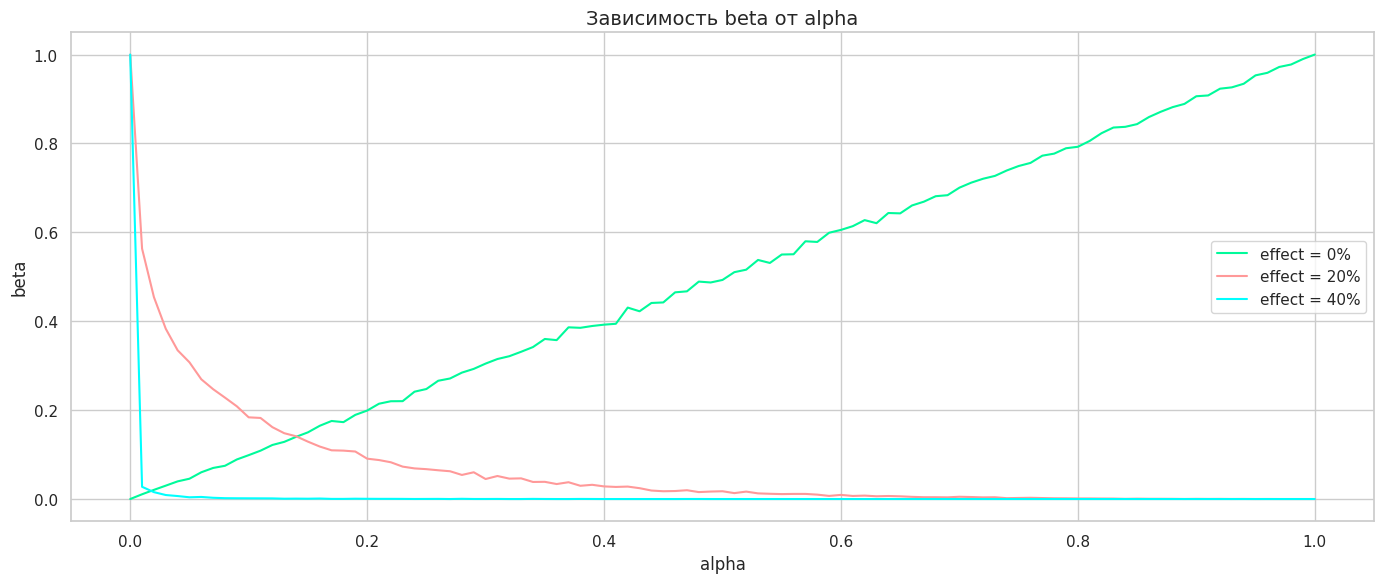

In [115]:
sns.set(style='whitegrid')
plt.figure(figsize=(14, 6))

plt.plot(rng, alpha_values, color='#00FA9A', label='effect = 0%')
plt.plot(rng, beta_values_20, color='#ff9999', label='effect = 20%')
plt.plot(rng, beta_values_40, color='#00FFFF', label='effect = 40%')

plt.title('Зависимость beta от alpha', fontsize=14)
plt.xlabel('alpha', fontsize=12)
plt.ylabel('beta', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем.

In [113]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

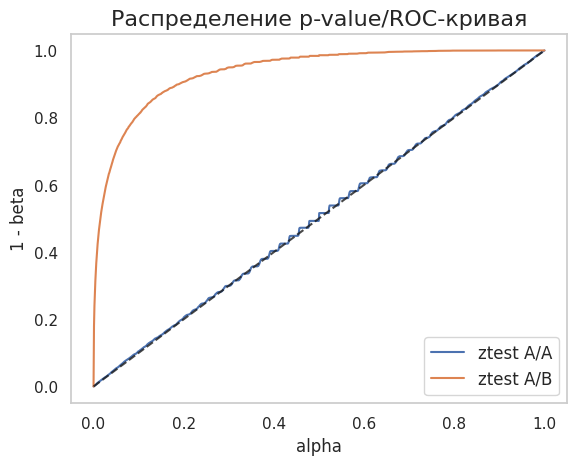

In [114]:
n_sim = 10**4
sample_size = 1000
p_control = 0.2
effect = 0.2

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x_control, x_treatment = gen_sample(n_obs, effect, p_control)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    # сгенерируем ещё одну тестовую выборку, чтобы убедиться, что в случае когда выборки совпали,
    # наш тест работает корректно и не находит разницу
    x_control_again, _ = gen_sample(n_obs, effect, p_control)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    x_control_again, _ = gen_sample(1000, 0, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    dict_pvalues['ztest A/A'].append(pval_aa)
    dict_pvalues['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)

Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $\alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [2 балла]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

In [139]:
def simulate_pvalues(n_sim, n_obs_list, effect, p_control):
    results = defaultdict(list)
    for n_obs in tqdm(n_obs_list):
        pvals = []
        for _ in range(n_sim):
            x_control, x_treatment = gen_sample(n_obs, effect, p_control)
            _, pval_ab = asy_mean_test(x_control, x_treatment)
            pvals.append(pval_ab)
        results[n_obs] = pvals
    return results

In [160]:
def plot_roc_curves(results):
    plt.figure(figsize=(10, 6))
    xseq = np.linspace(0, 1, 100)
    for n_obs, pvalues in results.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=f'n={n_obs}')

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.xlabel('Уровень значимости (α)', fontsize=12)
    plt.ylabel('Мощность теста (1 - β)', fontsize=12)
    plt.title('ROC-кривые для разных размеров выборки', fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-39-e26b351031b0>:10: RuntimeWarning: invalid value encountered in scalar divide
  z_obs = (mean_t - mean_c) / np.sqrt(mean_t * (1 - mean_t) / len(x_treatment) + mean_c * (1 - mean_c) / len(x_control))
100%|██████████| 4/4 [01:12<00:00, 18.08s/it]


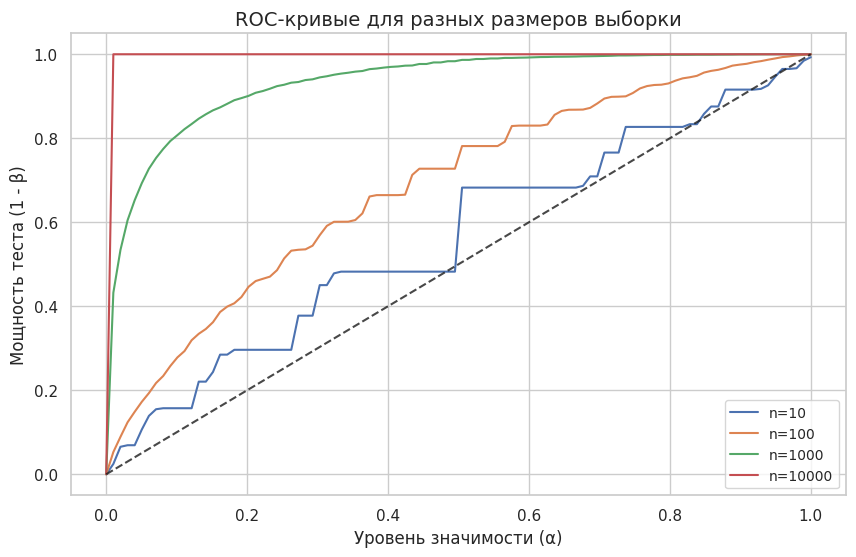

In [141]:
n_sim = 10**4
n_obs_list = [10, 100, 1000, 10000]
effect = 0.2
p_control = 0.2

results = simulate_pvalues(n_sim, n_obs_list, effect, p_control)
plot_roc_curves(results)

__ё) [1 балл]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают.

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись.

Екатерина пришла к вам и между вами состоялся следующий диалог:

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь?
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать?
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да?
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да.
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

Нарисуйте для Екатерины такую табличку. Не забудьте перевести общее количество наблюдений в дни.

In [149]:
import pandas as pd

In [153]:
order = 10**6  # общее число заказов
p_a = 0.1
p_b = 0.11
mde = p_b - p_a
count_poll = order * 0.1  # получают опрос
count_answer_per_group = count_poll * 0.05 / 2  # отвечают на группу в день

alphas = [0.01, 0.05]
betas = [0.1, 0.2]

results = []

for alpha in alphas:
    for beta in betas:
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(1 - beta)

        var_a = p_a * (1 - p_a)
        var_b = p_b * (1 - p_b)

        n = (var_a + var_b) * (z_alpha + z_beta)**2 / mde**2
        days = np.ceil(n / count_answer_per_group)

        results.append({
            'alpha': alpha,
            'beta': beta,
            'z_alpha': round(z_alpha, 2),
            'z_beta': round(z_beta, 2),
            'var_a': round(var_a, 2),
            'var_b': round(var_b, 2),
            'Размер выборки на группу': int(np.round(n)),
            'Дней теста': int(days)
        })

df = pd.DataFrame(results)
df = df.sort_values(['alpha', 'beta'])
df = df[['alpha', 'beta', 'z_alpha', 'z_beta', 'var_a', 'var_b',
         'Размер выборки на группу', 'Дней теста']]
df

,alpha,beta,z_alpha,z_beta,var_a,var_b,Размер выборки на группу,Дней теста
0,0.01,0.1,2.58,1.28,0.09,0.1,27958,12
1,0.01,0.2,2.58,0.84,0.09,0.1,21945,9
2,0.05,0.1,1.96,1.28,0.09,0.1,19743,8
3,0.05,0.2,1.96,0.84,0.09,0.1,14748,6


__ж) [1 балл]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [167]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

In [168]:
def simulate_pvalues_pareto(n_sim, n_obs, effect, b_list):
    results = defaultdict(list)
    for b in tqdm(b_list):
        pvals = []
        for _ in range(n_sim):
            x_control, x_treatment = gen_sample(n_obs, effect, b)
            _, pval_ab = asy_mean_test(x_control, x_treatment)
            pvals.append(pval_ab)
        results[b] = pvals
    return results

In [169]:
def plot_roc_curves_pareto(results):
    plt.figure(figsize=(10, 6))
    xseq = np.linspace(0, 1, 100)
    for b, pvalues in results.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=f'b={b}')

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.xlabel('Уровень значимости (α)', fontsize=12)
    plt.ylabel('Мощность теста (1 - β)', fontsize=12)
    plt.title('ROC-кривые для разных b', fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-39-e26b351031b0>:10: RuntimeWarning: invalid value encountered in sqrt
  z_obs = (mean_t - mean_c) / np.sqrt(mean_t * (1 - mean_t) / len(x_treatment) + mean_c * (1 - mean_c) / len(x_control))
100%|██████████| 3/3 [00:53<00:00, 17.98s/it]


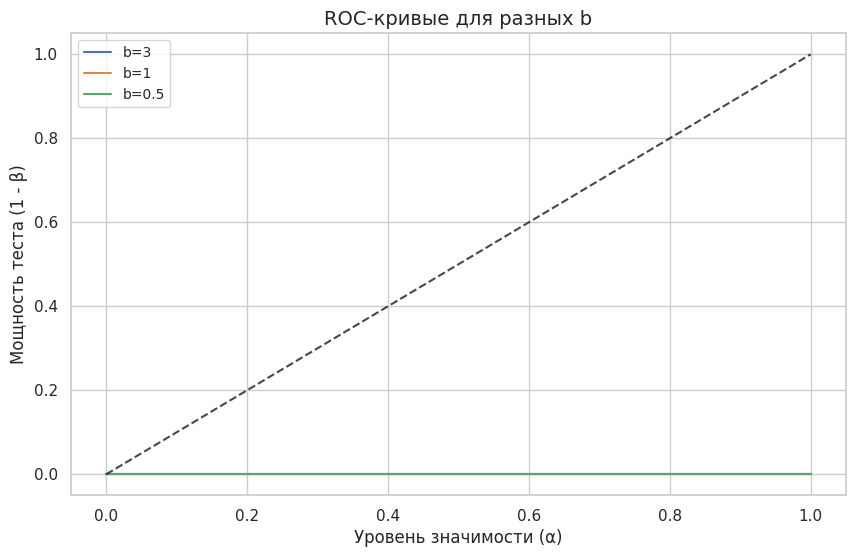

In [171]:
n_sim = 10**4
n_obs = 1000
effect = 0.2
p_control = 0.2
b_list = [3, 1, 0.5]
results = simulate_pvalues_pareto(n_sim, n_obs, effect, b_list)
plot_roc_curves_pareto(results)

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

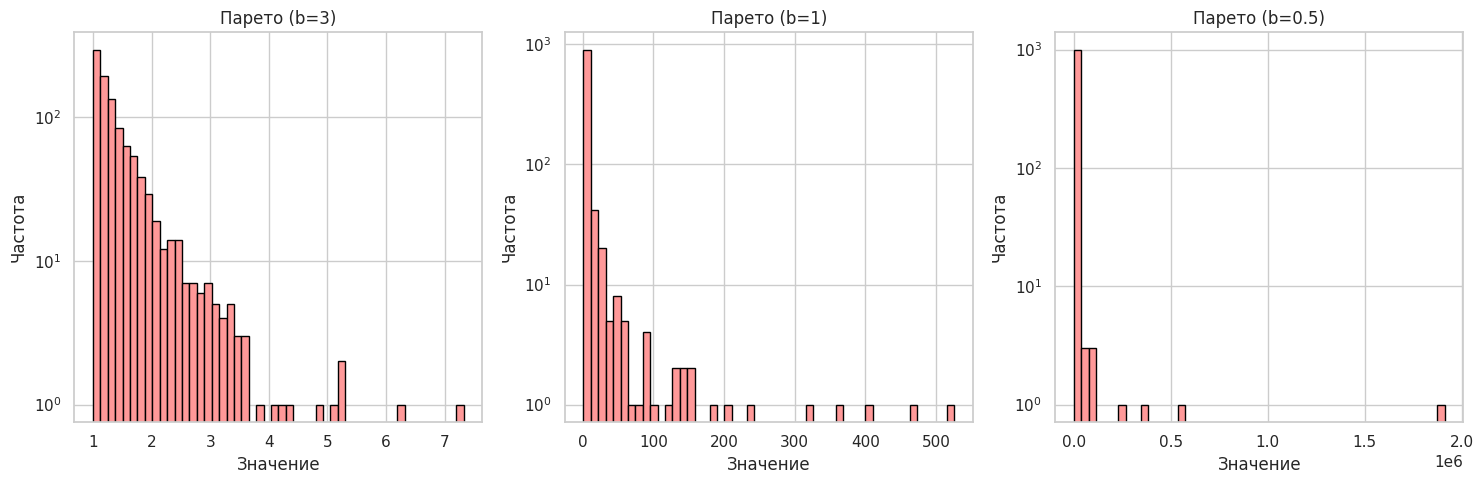

In [174]:
def plot_pareto_histograms(b_list, n_obs=1000):
    plt.figure(figsize=(15, 5))

    for i, b in enumerate(b_list, 1):
        sample = stats.pareto(b=b).rvs(n_obs)
        plt.subplot(1, 3, i)
        plt.hist(sample, bins=50, color='#ff9999', edgecolor='black')
        plt.title(f'Парето (b={b})')
        plt.xlabel('Значение')
        plt.ylabel('Частота')
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

b_list = [3, 1, 0.5]
plot_pareto_histograms(b_list)

У распределения Парето не всегда существует дисперсия. Это ломает предпосылки ЦПТ и АБ-тест разваливается.

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог.

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода.
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии.

Об этом мы и будем говорить на следующих парах.